## Adapted code from Breno Orzari, "VAE_Gauss".

Available in: https://colab.research.google.com/drive/1zfmanIeKsla96cI7LgPhebqz0wuJ4qzZ?usp=sharing

In [ ]:
import timeit
start_time = timeit.default_timer()
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from scipy.stats import kstest
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


$H_0$: the samples have the same distribution

$H_A$: the samples have not the same distribution

In [ ]:
def critic_ks_test(D, n):
    # table of critical values for the kolmogorov-smirnov test - 95% confidence
    # Source: https://www.soest.hawaii.edu/GG/FACULTY/ITO/GG413/K_S_Table_one_Sample.pdf
    # Source: http://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/
    # alpha = 0.2 (80% confidential level)

    if n <= 40:
        ks_list = [0.90000, 0.68377, 0.56481, 0.49265, 0.44697, 0.41035, 0.38145, 0.35828, 0.33907, 0.32257,
                      0.30826, 0.29573, 0.28470, 0.27481, 0.26588, 0.25778, 0.25039, 0.24360, 0.23735, 0.23156,
                      0.22617, 0.22115, 0.21645, 0.21205, 0.20790, 0.20399, 0.20030, 0.19680, 0.19348, 0.19032,
                      0.18732, 0.18445, 0.18171, 0.17909, 0.17659, 0.17418, 0.17188, 0.16966, 0.16753, 0.16547,
                      0.16349, 0.16158, 0.15974, 0.15796, 0.15623, 0.15457, 0.15295, 0.15139, 0.14987, 0.14840]
        critic_ks = ks_list[n - 1]
    elif n > 50:
        critic_ks = 1.07275/(np.sqrt(n))
    else:
        pass

    if critic_ks >= D:
        return "DO NOT REJECT H0"
    else:
        return "REJECT H0"

In [ ]:
# Read dpt distribution file as numpy array and then converts to pytorch tensor
#x_daughters = np.loadtxt('./../Skims/data_D0_daughtersPT_trk1_trk2.txt') # Local
x_daughters = np.loadtxt('data_D0_daughtersPT_trk1_trk2.txt') # Google Colab
org_x_daughters = x_daughters # Original input data
x_daughters = (x_daughters - np.mean(x_daughters)) / np.std(x_daughters) # Normalized input data (x-mean)/std
x_daughters = torch.from_numpy(x_daughters)
x_daughters = x_daughters.to(torch.float32)

# Dividing our data to train/eval/test (50/25/25)%
x_daughters_div = torch.tensor_split(x_daughters, 2)
x_train = x_daughters_div[0]
x_val, x_test = torch.tensor_split(x_daughters_div[1], 2)

nTrain = x_train.size()[0]
nVal = x_val.size()[0]
nTest = x_test.size()[0]

nVar = x_daughters.size()[1]
nHidden = 2205
nLatent = 215

lr = 2e-3
batch_size = 15
epochs = 15

epochs_list, train_losses, eval_losses = [i for i in range(epochs)], [], []

nBins = 60
r = [1, 3.5]

In [ ]:
# Defining our DataLoaders
trainloader = torch.utils.data.DataLoader(x_train, shuffle=True, batch_size=batch_size) # Train
valloader = torch.utils.data.DataLoader(x_val, shuffle=False, batch_size=batch_size) # Eval
testloader = torch.utils.data.DataLoader(x_test, shuffle=False, batch_size=batch_size) # Test

In [ ]:
# VAE class with inheritance from nn.Module
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Autoencoding architeture
        self.fc1 = nn.Linear(nVar, nHidden) # Encoder
        self.fc2 = nn.Linear(nHidden, nHidden) # Encoder
        self.fc21 = nn.Linear(nHidden, nLatent) # Mean
        self.fc22 = nn.Linear(nHidden, nLatent) # Std

        self.fc3 = nn.Linear(nLatent, nHidden) # Decoder
        self.fc31 = nn.Linear(nHidden, nHidden) # Decoder
        self.fc4 = nn.Linear(nHidden, nVar) # Decoder

    # Encoding func
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        #h = torch.tanh(self.fc2(h))
        return self.fc21(h), self.fc22(h) # Mean, Std

    def sampling(self, mu, std): # Reparameterization trick
        eps = torch.randn_like(std)
        return 0.5*((eps * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, nVar))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE() # Defining VAE as our model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr) # Implements Adam algorithm to our model parameters (Adam algorithm is a alternative to the classic stochastic gradient descent to update the weights based on
# training dataset)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, # Applying a scheduler to the optimizer
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

# Defining the loss fucntion
def loss_function(y, x, mu, std):
    loss = nn.MSELoss(reduction='sum') # The reduction='sum' parameters return the sum of all MSE
    ERR = loss(y, x)
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2) # KL Divergence
    return ERR + KLD, -ERR, -KLD

In [ ]:
count=0
err_l, kld_l, n_wu, terrl, tkldl, update = [], [], [], [], [], []
for epoch in range(epochs):

    train_loss = 0
    for batch_idx, (data) in enumerate(trainloader): # batch_idx = iteration index
        model.train()
        bsize = data.shape[0] # Define a variable with the size of epoch's minibatch
        recon_batch, mu, std = model(data) # Call our model
        loss, err, kld = loss_function(recon_batch, data, mu, std) # Call the loss function and the KLD
        loss.backward() # Compute tensor gradient
        train_loss += loss.item()
        optimizer.step() # Update optimizer parameters
        optimizer.zero_grad() # Reset tensor gradient
        err_l.append(err.item()/bsize) # minibatch mean error
        kld_l.append(kld.item()/bsize) # minibatch mean KLD
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          eval_loss = 0
          for batch_idx, datav in enumerate(valloader):
            model.eval()
            trecon, tmu, tstd = model(datav)
            tloss, terr, tkld = loss_function(trecon, datav, tmu, tstd)
            eval_loss += tloss.item()
            terrl.append(terr.item()/datav.shape[0])
            tkldl.append(tkld.item()/datav.shape[0])
            update.append(count)

    train_losses.append(train_loss / len(trainloader.dataset))
    eval_losses.append(eval_loss / len(valloader.dataset))
    scheduler.step(train_loss / len(trainloader.dataset)) # Do the scheduler step

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad(): # Disables gradient calculation to reduce the computational cost
        for data in testloader:
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += loss.item()

    test_loss /= len(testloader.dataset)
    print(f'Error = {err_l[-1]:.4f} | KLD = {kld_l[-1]:.4f} | Loss = {test_loss:.4f}')

====> Epoch: 0 Average loss: 647.3110
Error = -7.5387 | KLD = -708.0476 | Loss = 677.5301
====> Epoch: 1 Average loss: 611.3914
Error = -3.4664 | KLD = -435.2769 | Loss = 453.9830
====> Epoch: 2 Average loss: 620.8992
Error = -3.3454 | KLD = -741.1048 | Loss = 801.7820
====> Epoch: 3 Average loss: 665.0501
Error = -1.9782 | KLD = -606.6833 | Loss = 626.1748
====> Epoch: 4 Average loss: 360.9638
Error = -2.5702 | KLD = -160.5168 | Loss = 173.9785
====> Epoch: 5 Average loss: 239.1346
Error = -0.1913 | KLD = -162.2896 | Loss = 343.1130
====> Epoch: 6 Average loss: 310.5276
Error = -3.3918 | KLD = -352.8930 | Loss = 385.4248
====> Epoch: 7 Average loss: 181.5168
Error = -2.7638 | KLD = -160.9535 | Loss = 156.9013
====> Epoch: 8 Average loss: 149.6689
Error = -2.4942 | KLD = -113.1931 | Loss = 159.2385
====> Epoch: 9 Average loss: 124.5180
Error = -1.6569 | KLD = -110.0001 | Loss = 174.3008
====> Epoch: 10 Average loss: 93.0487
Error = -1.8893 | KLD = -51.0031 | Loss = 50.8222
====> Epoch:

In [ ]:
model.eval()
a = x_train
recon, mu, std = model(a)
b = recon

a = a.numpy()
b = b.detach().numpy()
a = a.flatten()
b = b.flatten()
D, ks_significance = kstest(b, a, N=len(b))
verifier = critic_ks_test(D, len(b))
print(verifier)

REJECT H0


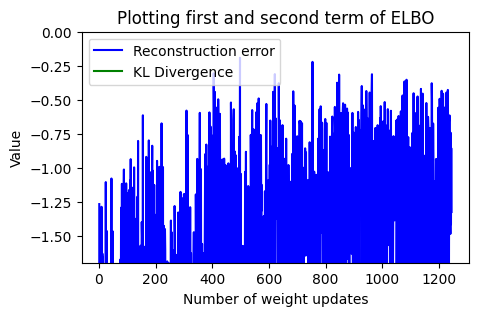

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.ylim(-1.7, 0)
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

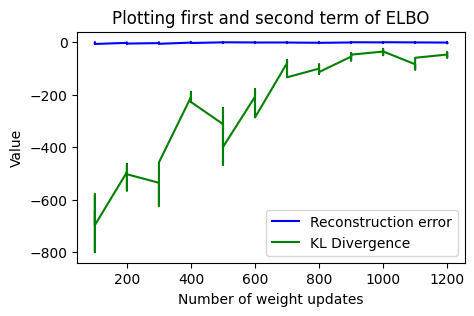

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(update, terrl, 'b', label='Reconstruction error')
plt.plot(update, tkldl, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

Generated samples trying to reproduce train dataset:

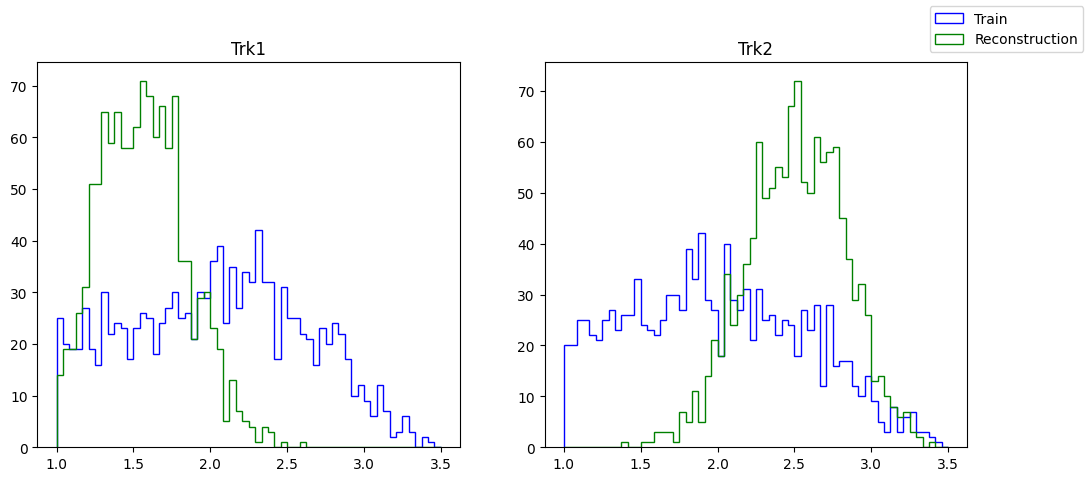

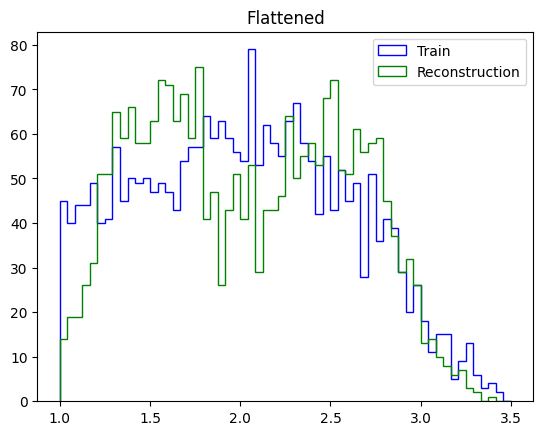

In [ ]:
model.eval()
a = x_train * np.std(org_x_daughters) + np.mean(org_x_daughters)
recon, mu, std = model(a)
b = recon * np.std(org_x_daughters) + np.mean(org_x_daughters)

canvas, (g1, g2) = plt.subplots(1, 2)
g1.set_title("Trk1")
g1.hist(a[:,0], bins = nBins, range = r, histtype = 'step', color = 'blue')
g1.hist(b[:,0].detach().numpy(), bins = nBins, range = r, histtype = 'step', color = 'green')
g2.set_title("Trk2")
g2.hist(a[:,1], bins = nBins, range = r, histtype = 'step', color = 'blue')
g2.hist(b[:,1].detach().numpy(), bins = nBins, range = r, histtype = 'step', color = 'green')
canvas.legend(('Train', 'Reconstruction'))
canvas.set_figwidth(12)
canvas.set_figheight(5)
plt.show()

a = a.flatten()
b = b.detach().flatten()
plt.title("Flattened")
plt.hist(a, bins = nBins, range = r, histtype = 'step', color='blue')
plt.hist(b, bins = nBins, range = r, histtype = 'step', color='green')
plt.legend(('Train', 'Reconstruction'))
plt.show()

Generated samples trying to reproduce test dataset:

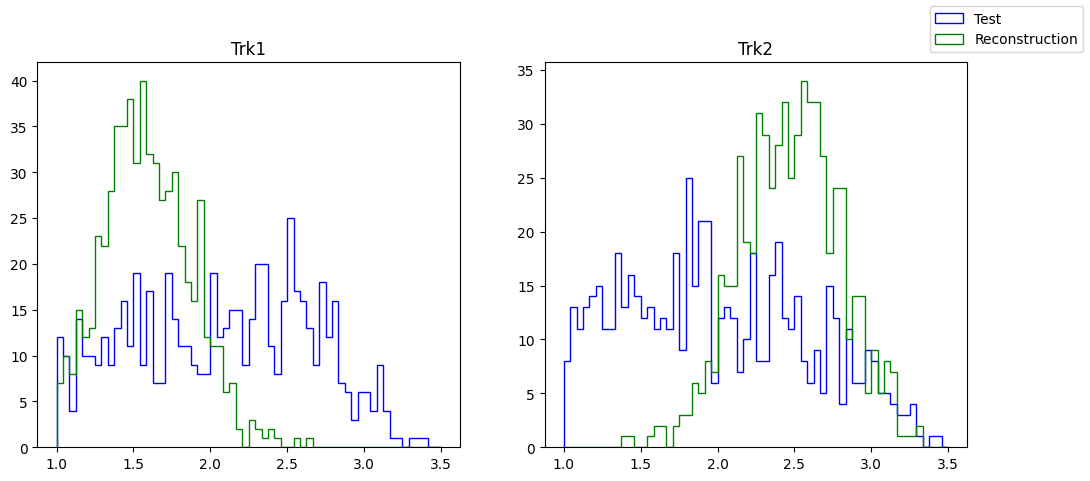

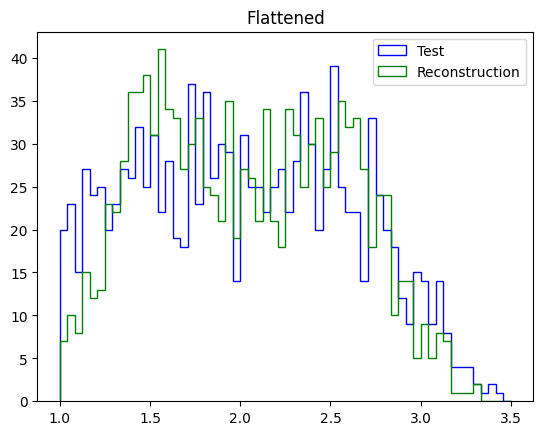

KstestResult(statistic=0.05348460291734198, pvalue=0.05859451419968325, statistic_location=1.2568399, statistic_sign=-1)

In [ ]:
model.eval()
a = x_test * np.std(org_x_daughters) + np.mean(org_x_daughters)
recon, mu, std = model(a)
b = recon * np.std(org_x_daughters) + np.mean(org_x_daughters)
canvas, (g1, g2) = plt.subplots(1, 2)
g1.set_title("Trk1")
g1.hist(a[:,0], bins = nBins, range = r, histtype = 'step', color = 'blue')
g1.hist(b[:,0].detach().numpy(), bins = nBins, range = r, histtype = 'step', color = 'green')
g2.set_title("Trk2")
g2.hist(a[:,1], bins = nBins, range = r, histtype = 'step', color = 'blue')
g2.hist(b[:,1].detach().numpy(), bins = nBins, range = r, histtype = 'step', color = 'green')
canvas.legend(('Test', 'Reconstruction'))
canvas.set_figwidth(12)
canvas.set_figheight(5)
plt.show()

a = a.flatten()
b = b.detach().flatten()
plt.title("Flattened")
plt.hist(a, bins = nBins, range = r, histtype = 'step', color='blue')
plt.hist(b, bins = nBins, range = r, histtype = 'step', color='green')
plt.legend(('Test', 'Reconstruction'))
plt.show()

kstest(b, a)

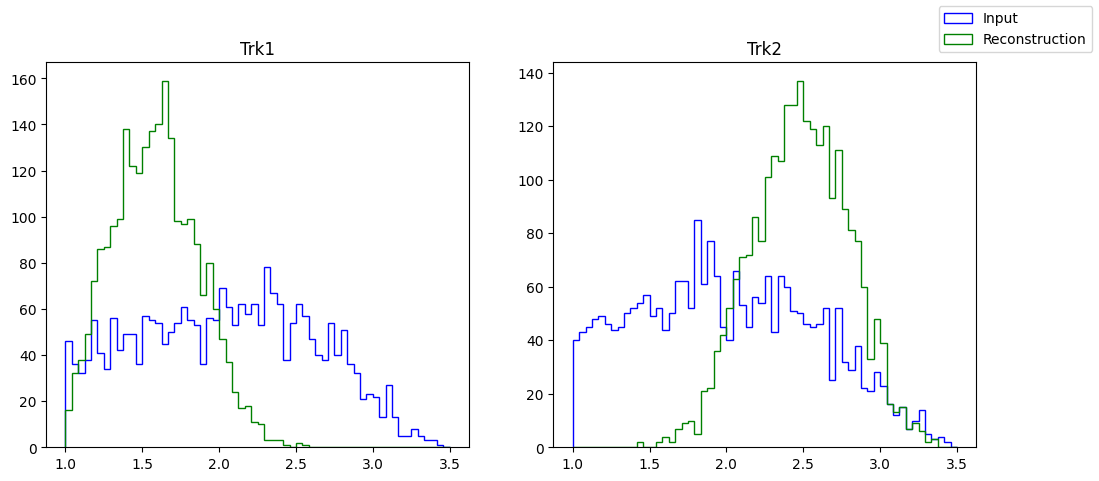

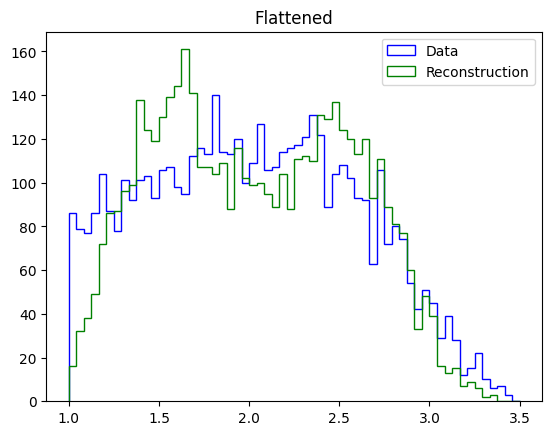

REJECT H0
0.03928716079384366
4938


In [ ]:
model.eval()
a = x_daughters * np.std(org_x_daughters) + np.mean(org_x_daughters)
recon, mu, std = model(a)
b = recon * np.std(org_x_daughters) + np.mean(org_x_daughters)


canvas, (g1, g2) = plt.subplots(1, 2)
g1.set_title("Trk1")
g1.hist(a[:,0], bins = nBins, range = r, histtype = 'step', color = 'blue')
g1.hist(b[:,0].detach().numpy(), bins = nBins, range = r, histtype = 'step', color = 'green')
g2.set_title("Trk2")
g2.hist(a[:,1], bins = nBins, range = r, histtype = 'step', color = 'blue')
g2.hist(b[:,1].detach().numpy(), bins = nBins, range = r, histtype = 'step', color = 'green')
canvas.legend(('Input', 'Reconstruction'))
canvas.set_figwidth(12)
canvas.set_figheight(5)
plt.show()

a = a.flatten()
b = b.detach().flatten()
plt.title("Flattened")
plt.hist(a, bins = nBins, range = r, histtype = 'step', color='blue')
plt.hist(b, bins = nBins, range = r, histtype = 'step', color='green')
plt.legend(('Data', 'Reconstruction'))
plt.show()

a = a.numpy()
b = b.numpy()
D, ks_significance = kstest(b, a, N=len(b))
print(critic_ks_test(D, len(b)))
print(D)
print(len(b))

In [ ]:
# Elapsed time
elapsed = timeit.default_timer() - start_time
print(f"{int(elapsed)} s\n")

# Results
print(f"Error = {err_l[-1]:.4f} | KLD = {kld_l[-1]:.4f}")

7487 s

Error = -1.3268 | KLD = -28.2339


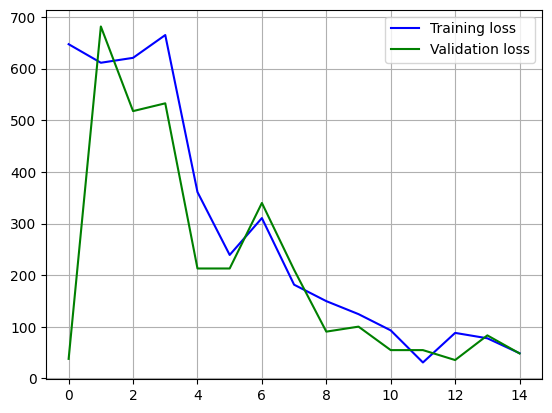

In [ ]:
plt.plot(epochs_list, train_losses, 'b', label='Training loss')
plt.plot(epochs_list, eval_losses, 'g', label='Validation loss')
plt.grid()
plt.legend()